In [24]:
import os
import requests
import tarfile
import email
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from bs4 import BeautifulSoup
from transformers import BertTokenizer

# PART 1: Download and process the SpamAssassin corpus
def download_spamassassin():
    """Download and extract SpamAssassin corpus"""
    os.makedirs('/content/gdrive/MyDrive/email_bert/datasets/spamassassin', exist_ok=True)

    # SpamAssassin URLs
    urls = [
        'https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2',
        'https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2',
        'https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2'
    ]

    for url in urls:
        filename = url.split('/')[-1]
        filepath = f'/content/gdrive/MyDrive/email_bert/datasets/spamassassin/{filename}'

        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            response = requests.get(url, stream=True)
            with open(filepath, 'wb') as f:
                for data in tqdm(response.iter_content(chunk_size=1024)):
                    f.write(data)

        print(f"Extracting {filename}...")
        extract_dir = '/content/gdrive/MyDrive/email_bert/datasets/spamassassin'
        with tarfile.open(filepath, 'r:bz2') as tar:
            tar.extractall(extract_dir)

        # Remove tar file
        os.remove(filepath)


def process_spamassassin():
    """Process extracted emails into a DataFrame"""
    print("Processing emails...")
    texts = []
    labels = []

    # Process ham emails
    for ham_dir in ['easy_ham', 'hard_ham']:
        dir_path = f'/content/gdrive/MyDrive/email_bert/datasets/spamassassin/{ham_dir}'
        if os.path.exists(dir_path):
            for filename in tqdm(os.listdir(dir_path)):
                if filename == 'cmds':
                    continue
                filepath = os.path.join(dir_path, filename)
                try:
                    with open(filepath, 'r', encoding='latin-1') as f:
                        content = f.read()

                    msg = email.message_from_string(content)

                    # Extract body
                    body = ""
                    if msg.is_multipart():
                        for part in msg.walk():
                            content_type = part.get_content_type()
                            if content_type == 'text/plain' or content_type == 'text/html':
                                payload = part.get_payload(decode=True)
                                if payload:
                                    body += payload.decode('latin-1', errors='ignore')
                    else:
                        payload = msg.get_payload(decode=True)
                        if payload:
                            body = payload.decode('latin-1', errors='ignore')

                    texts.append(body)
                    labels.append(0)  # 0 for ham
                except Exception as e:
                    print(f"Error with {filepath}: {e}")

    # Process spam emails
    spam_dir = '/content/gdrive/MyDrive/email_bert/datasets/spamassassin/spam'
    if os.path.exists(spam_dir):
        for filename in tqdm(os.listdir(spam_dir)):
            if filename == 'cmds':
                continue
            filepath = os.path.join(spam_dir, filename)
            try:
                with open(filepath, 'r', encoding='latin-1') as f:
                    content = f.read()

                msg = email.message_from_string(content)

                # Extract body
                body = ""
                if msg.is_multipart():
                    for part in msg.walk():
                        content_type = part.get_content_type()
                        if content_type == 'text/plain' or content_type == 'text/html':
                            payload = part.get_payload(decode=True)
                            if payload:
                                body += payload.decode('latin-1', errors='ignore')
                else:
                    payload = msg.get_payload(decode=True)
                    if payload:
                        body = payload.decode('latin-1', errors='ignore')

                texts.append(body)
                labels.append(1)  # 1 for spam
            except Exception as e:
                print(f"Error with {filepath}: {e}")

    # Create DataFrame and save to CSV
    df = pd.DataFrame({'text': texts, 'label': labels})
    df.to_csv('/content/gdrive/MyDrive/email_bert/datasets/spamassassin/spamassassin.csv', index=False)
    print(f"Dataset created with {len(df)} emails")
    print(f"Ham emails: {sum(df['label'] == 0)}")
    print(f"Spam emails: {sum(df['label'] == 1)}")

    return df


Mounted at /content/gdrive
Using device: cuda
Successfully loaded model weights from checkpoint!


Epoch 1/3:  14%|█▍        | 52/372 [00:08<00:48,  6.58it/s]

Batch 50, Loss: 0.1196


Epoch 1/3:  27%|██▋       | 102/372 [00:16<00:54,  4.97it/s]

Batch 100, Loss: 0.6269


Epoch 1/3:  41%|████      | 152/372 [00:24<00:31,  6.95it/s]

Batch 150, Loss: 0.5883


Epoch 1/3:  54%|█████▍    | 202/372 [00:32<00:24,  6.81it/s]

Batch 200, Loss: 0.3828


Epoch 1/3:  68%|██████▊   | 252/372 [00:39<00:17,  6.99it/s]

Batch 250, Loss: 0.1733


Epoch 1/3:  81%|████████  | 302/372 [00:49<00:16,  4.37it/s]

Batch 300, Loss: 0.2941


Epoch 1/3:  94%|█████████▍| 351/372 [00:56<00:03,  5.39it/s]

Batch 350, Loss: 0.4090


Epoch 1/3: 100%|██████████| 372/372 [00:59<00:00,  6.22it/s]


Epoch 1/3, Average training loss: 0.4038


Evaluating: 100%|██████████| 42/42 [00:02<00:00, 14.60it/s]


Accuracy: 0.8308
              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91       282
         1.0       0.11      0.02      0.03        49

    accuracy                           0.83       331
   macro avg       0.48      0.50      0.47       331
weighted avg       0.74      0.83      0.78       331



Epoch 2/3:  14%|█▍        | 52/372 [00:08<00:57,  5.61it/s]

Batch 50, Loss: 0.2072


Epoch 2/3:  27%|██▋       | 101/372 [00:16<00:39,  6.93it/s]

Batch 100, Loss: 0.1457


Epoch 2/3:  41%|████      | 152/372 [00:24<00:30,  7.17it/s]

Batch 150, Loss: 0.3548


Epoch 2/3:  54%|█████▍    | 202/372 [00:32<00:24,  7.02it/s]

Batch 200, Loss: 0.4403


Epoch 2/3:  68%|██████▊   | 252/372 [00:40<00:18,  6.46it/s]

Batch 250, Loss: 0.7061


Epoch 2/3:  81%|████████  | 302/372 [00:48<00:12,  5.78it/s]

Batch 300, Loss: 0.4213


Epoch 2/3:  95%|█████████▍| 352/372 [00:55<00:02,  6.93it/s]

Batch 350, Loss: 0.3039


Epoch 2/3: 100%|██████████| 372/372 [00:59<00:00,  6.20it/s]


Epoch 2/3, Average training loss: 0.2946


Evaluating: 100%|██████████| 42/42 [00:04<00:00,  9.58it/s]


Accuracy: 0.8610
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.92       282
         1.0       0.67      0.12      0.21        49

    accuracy                           0.86       331
   macro avg       0.77      0.56      0.57       331
weighted avg       0.84      0.86      0.82       331



Epoch 3/3:  14%|█▍        | 52/372 [00:07<00:46,  6.92it/s]

Batch 50, Loss: 0.1803


Epoch 3/3:  27%|██▋       | 101/372 [00:16<00:51,  5.25it/s]

Batch 100, Loss: 0.1897


Epoch 3/3:  41%|████      | 152/372 [00:25<00:33,  6.52it/s]

Batch 150, Loss: 0.1712


Epoch 3/3:  54%|█████▍    | 202/372 [00:33<00:22,  7.55it/s]

Batch 200, Loss: 0.4021


Epoch 3/3:  68%|██████▊   | 252/372 [00:41<00:17,  6.90it/s]

Batch 250, Loss: 0.5691


Epoch 3/3:  81%|████████  | 302/372 [00:49<00:10,  6.66it/s]

Batch 300, Loss: 0.2168


Epoch 3/3:  95%|█████████▍| 352/372 [00:57<00:02,  7.41it/s]

Batch 350, Loss: 0.2657


Epoch 3/3: 100%|██████████| 372/372 [01:00<00:00,  6.13it/s]


Epoch 3/3, Average training loss: 0.2374


Evaluating: 100%|██████████| 42/42 [00:02<00:00, 14.12it/s]


Accuracy: 0.8973
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       282
         1.0       0.80      0.41      0.54        49

    accuracy                           0.90       331
   macro avg       0.85      0.70      0.74       331
weighted avg       0.89      0.90      0.88       331



Final evaluation: 100%|██████████| 42/42 [00:04<00:00,  9.83it/s]


Confusion matrix:
[[277   5]
 [ 29  20]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       282
         1.0       0.80      0.41      0.54        49

    accuracy                           0.90       331
   macro avg       0.85      0.70      0.74       331
weighted avg       0.89      0.90      0.88       331

Model saved to /content/drive/MyDrive/email_bert/spam_classifier.pth


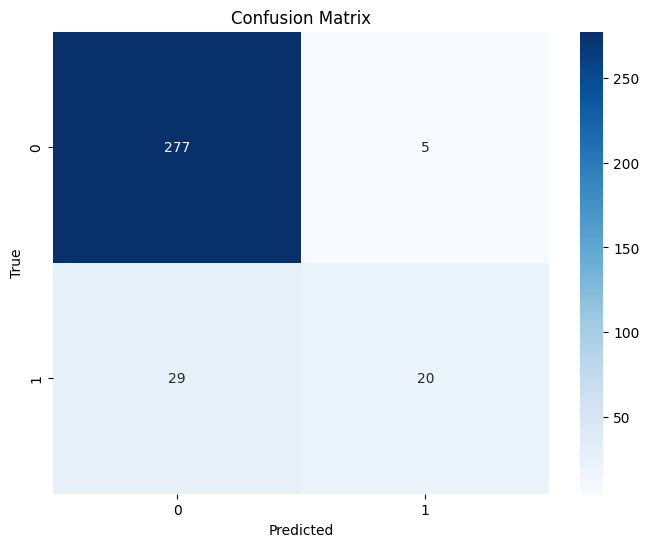

In [26]:

from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads

        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.output_linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, mask=None):
        batch_size = x.size(0)

        # Linear projections
        q = self.query(x).view(batch_size, -1, self.num_heads, self.head_size).transpose(1, 2)
        k = self.key(x).view(batch_size, -1, self.num_heads, self.head_size).transpose(1, 2)
        v = self.value(x).view(batch_size, -1, self.num_heads, self.head_size).transpose(1, 2)

        # Attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_size ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        context = torch.matmul(attn, v)

        # Reshape
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.hidden_size)
        output = self.output_linear(context)

        return output

# Define FeedForward network
class FeedForward(nn.Module):
    def __init__(self, hidden_size, ff_size):
        super().__init__()
        self.fc1 = nn.Linear(hidden_size, ff_size)
        self.fc2 = nn.Linear(ff_size, hidden_size)

    def forward(self, x):
        return self.fc2(F.gelu(self.fc1(x)))

# Define EncoderBlock
class EncoderBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, ff_size, dropout=0.1):
        super().__init__()
        self.layernorm = nn.LayerNorm(hidden_size)
        self.self_multihead = MultiHeadAttention(hidden_size, num_heads)
        self.feed_forward = FeedForward(hidden_size, ff_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention
        attention_output = self.self_multihead(self.layernorm(x), mask)
        x = x + self.dropout(attention_output)

        # Feed-forward
        ff_output = self.feed_forward(self.layernorm(x))
        x = x + self.dropout(ff_output)

        return x

# Define BERTEmbedding
class BERTEmbedding(nn.Module):
    def __init__(self, vocab_size, hidden_size, max_seq_len=64, dropout=0.1):
        super().__init__()
        self.token = nn.Embedding(vocab_size, hidden_size)
        self.segment = nn.Embedding(3, hidden_size)
        self.position = nn.Module()
        self.position.pe = nn.Parameter(torch.zeros(1, max_seq_len, hidden_size))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, segment=None):
        seq_len = x.size(1)

        # Token embedding
        token_embedding = self.token(x)

        # Position embedding
        position_embedding = self.position.pe[:, :seq_len, :]

        # Segment embedding
        if segment is not None:
            segment_embedding = self.segment(segment)
            embedding = token_embedding + position_embedding + segment_embedding
        else:
            embedding = token_embedding + position_embedding

        return self.dropout(embedding)

# Define BERT model
class BERT(nn.Module):
    def __init__(self, vocab_size, hidden_size=768, num_layers=12, num_heads=12, ff_size=3072, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size

        # Embedding
        self.embedding = BERTEmbedding(vocab_size, hidden_size, dropout=dropout)

        # Transformer blocks
        self.encoder_blocks = nn.ModuleList([
            EncoderBlock(hidden_size, num_heads, ff_size, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, segment=None, mask=None):
        # Create attention mask if not provided
        if mask is None:
            mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # Embedding
        x = self.embedding(x, segment)

        # Transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder(x, mask)

        return x

# Define NextSentencePrediction
class NextSentencePrediction(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.linear = nn.Linear(hidden_size, 2)

    def forward(self, x):
        return F.log_softmax(self.linear(x[:, 0]), dim=-1)

# Define MaskedLanguageModel
class MaskedLanguageModel(nn.Module):
    def __init__(self, hidden_size, vocab_size):
        super().__init__()
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=-1)

# Define BERTLM
class BERTLM(nn.Module):
    def __init__(self, bert_model, vocab_size):
        super().__init__()
        self.bert = bert_model
        self.next_sentence = NextSentencePrediction(bert_model.hidden_size)
        self.mask_lm = MaskedLanguageModel(bert_model.hidden_size, vocab_size)

    def forward(self, x, segment=None):
        bert_output = self.bert(x, segment)
        return self.next_sentence(bert_output), self.mask_lm(bert_output)

# Define EmailDataset for training
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding.get('token_type_ids', torch.zeros_like(encoding['attention_mask'])).flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# Define BERTSpamClassifier
class BERTSpamClassifier(nn.Module):
    def __init__(self, bert_model):
        super(BERTSpamClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 1)  # Binary classification

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Forward pass through BERT
        outputs = self.bert(input_ids, segment=token_type_ids)

        # Use the [CLS] token for classification
        pooled_output = outputs[:, 0]

        # Dropout and classify
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# PART 3: Main execution code
def main():
    # Set device
    import torch
    from torch import nn
    import torch.nn.functional as F

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')


    # 1. Download and process SpamAssassin
    if not os.path.exists('/content/gdrive/MyDrive/email_bert/datasets/spamassassin/spamassassin.csv'):
        download_spamassassin()
        df = process_spamassassin()
    else:
        df = pd.read_csv('/content/gdrive/MyDrive/email_bert/datasets/spamassassin/spamassassin.csv')

    # 2. Preprocess data
    def clean_text(text):
        import re
        # Clean HTML
        text = re.sub(r'<.*?>', '', str(text))
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        # Clean extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df['text'] = df['text'].apply(clean_text)

    # 3. Split data: 90% train, 10% test
    X_train, X_test, y_train, y_test = train_test_split(
        df['text'], df['label'], test_size=0.1, random_state=42
    )

    # 4. Load model and tokenizer
    import torch.serialization
    torch.serialization.add_safe_globals(['numpy._core.multiarray.scalar'])

    # Paths to your model and tokenizer
    MODEL_PATH = '/content/gdrive/MyDrive/email_bert/checkpoints/bert_email_epoch_4.pth'

    TOKENIZER_PATH = '/content/gdrive/MyDrive/email_bert/tokenizer/bert-email-vocab.txt'
    tokenizer = BertTokenizer(
        vocab_file=TOKENIZER_PATH,
        do_lower_case=True
    )

    # Create BERT model
    bert_model = BERT(vocab_size=len(tokenizer.vocab))
    bert_lm = BERTLM(bert_model, len(tokenizer.vocab))

    # Load checkpoint
    checkpoint = torch.load(MODEL_PATH, map_location='cpu', weights_only=False)

    # Load state dict
    try:
        bert_lm.load_state_dict(checkpoint['model_state_dict'])
        print("Successfully loaded model weights from checkpoint!")
    except Exception as e:
        print(f"Error loading model weights: {e}")

    # Create classifier
    spam_classifier = BERTSpamClassifier(bert_lm.bert)

    # 5. Create datasets and dataloaders
    MAX_LEN = 64  # Max sequence length

    train_dataset = EmailDataset(X_train.values, y_train.values, tokenizer, MAX_LEN)
    test_dataset = EmailDataset(X_test.values, y_test.values, tokenizer, MAX_LEN)

    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=8)

    # 6. Training
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(spam_classifier.parameters(), lr=2e-5)

    spam_classifier.to(device)

    # Training loop
    epochs = 3
    for epoch in range(epochs):
        # Training
        spam_classifier.train()
        train_loss = 0

        for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = spam_classifier(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs.squeeze(), labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if step % 50 == 0 and step > 0:
                print(f"Batch {step}, Loss: {loss.item():.4f}")

        avg_train_loss = train_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Average training loss: {avg_train_loss:.4f}")

        # Evaluation after each epoch
        spam_classifier.eval()
        y_preds = []
        y_true = []

        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                labels = batch['labels'].to(device)

                outputs = spam_classifier(input_ids, attention_mask, token_type_ids)
                preds = torch.sigmoid(outputs.squeeze()) > 0.5

                y_preds.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        # Calculate metrics
        accuracy = np.mean(np.array(y_preds) == np.array(y_true))
        print(f"Accuracy: {accuracy:.4f}")

        # Detailed metrics
        report = classification_report(y_true, y_preds)
        print(report)

    # 7. Final evaluation
    spam_classifier.eval()
    y_preds = []
    y_true = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Final evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = spam_classifier(input_ids, attention_mask, token_type_ids)
            preds = torch.sigmoid(outputs.squeeze()) > 0.5

            y_preds.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_preds)
    print("Confusion matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('/content/gdrive/MyDrive/email_bert/confusion_matrix.png')

    # Classification report
    report = classification_report(y_true, y_preds)
    print("Classification report:")
    print(report)

    # Save model
    torch.save(spam_classifier.state_dict(), '/content/gdrive/MyDrive/email_bert/spam_classifier.pth')
    print("Model saved to /content/drive/MyDrive/email_bert/spam_classifier.pth")

if __name__ == "__main__":
    main()